In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import tqdm

import torch
import torch.nn          as nn
from torch.utils.data    import Dataset, DataLoader
from torch.optim         import Adam

from matplotlib          import rcParams, rc
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import train        as tr
import neuralODE    as nODE

In [2]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1 ## if not 1, dan kan er geen tensor van gemaakt worden
epochs = 1
lr = 0.01

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [3]:
dirname = 'easy-mace2'

train, data_loader, test_loader = ds.get_data(dirname = dirname, batch_size=batch_size, kwargs=kwargs, plot = True, scale = None)

Dataset:
------------------------------
total # of samples: 6626
# training samples: 4638
# testing samples:  1988
            ratio:  0.3


In [4]:
enc = ae.Encoder( 466, 100, 10)
dec = ae.Decoder(10,100,466)

i = 7
n_test = train[i][0]
n_0=torch.from_numpy(n_test[:,0])
p = torch.from_numpy(train[i][1])
t=torch.from_numpy(train[i][2])

In [5]:
t.shape

torch.Size([15])

In [6]:
z_0= enc(n_0)

z_0

tensor([ 0.1103, -0.4419,  1.3435,  0.9206,  1.6525,  1.0866,  0.7849, -0.1710,
         2.3710,  1.8667], grad_fn=<LeakyReluBackward0>)

In [7]:
g = nODE.G(4,10)
z=z_0.view(1,10)
g_fun = nODE.G.forward(g,t,z,p)
print(g_fun)

tensor([[3.0253, 2.2384, 2.8218, 3.4053, 3.5320, 1.2202, 1.2751, 1.3999, 1.3583,
         2.5273]], grad_fn=<AddBackward0>)


In [4]:
model = nODE.Solver(p_dim=4,z_dim = 10, n_dim=466)

In [5]:
## Training & validating model

loss_train_all, loss_test_all = tr.train(model, lr, data_loader, test_loader, epochs, DEVICE)
n_test, n_test_hat, loss = tr.test(model, test_loader, DEVICE)

Model:         
learning rate: 0.01

>>> Training model...
	batch 4638 / 4638 , # nan 4636
		# nan: 4637 / 4638
	batch 1 / 1988
Epoch 1 complete! 	Average loss train:  nan 	Average loss test:  nan
 	DONE!

>>> Testing model...
	batch 1988 / 1988 , # nan 1987
Test loss: nan


In [9]:
n_s = model(n_0, p, t.view(1,-1))
n_s

tensor([[[ 9.8833e-02, -2.8906e-02,  1.3113e-01,  ..., -1.2936e-02,
           1.6915e-03, -1.2189e-02],
         [ 9.8330e-02, -2.9701e-02,  1.4128e-01,  ..., -1.3061e-02,
          -3.4806e-04, -1.3009e-02],
         [ 8.4362e-02, -3.0935e-02,  1.5642e-01,  ..., -1.3803e-02,
          -2.8652e-03, -1.4571e-02],
         ...,
         [ 3.1912e+31, -1.2083e+30,  1.6512e+31,  ...,  3.2018e+31,
          -5.4945e+30, -3.3700e+30],
         [-4.9260e+30,  1.3048e+31, -4.8908e+30,  ...,  2.1291e+31,
          -2.7734e+30,  3.1760e+30],
         [-7.0813e+30,  5.2350e+30, -3.3697e+29,  ..., -2.2977e+30,
          -6.3154e+30, -2.0612e+30]]], grad_fn=<ReshapeAliasBackward0>)

In [13]:
4638-4593


45

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

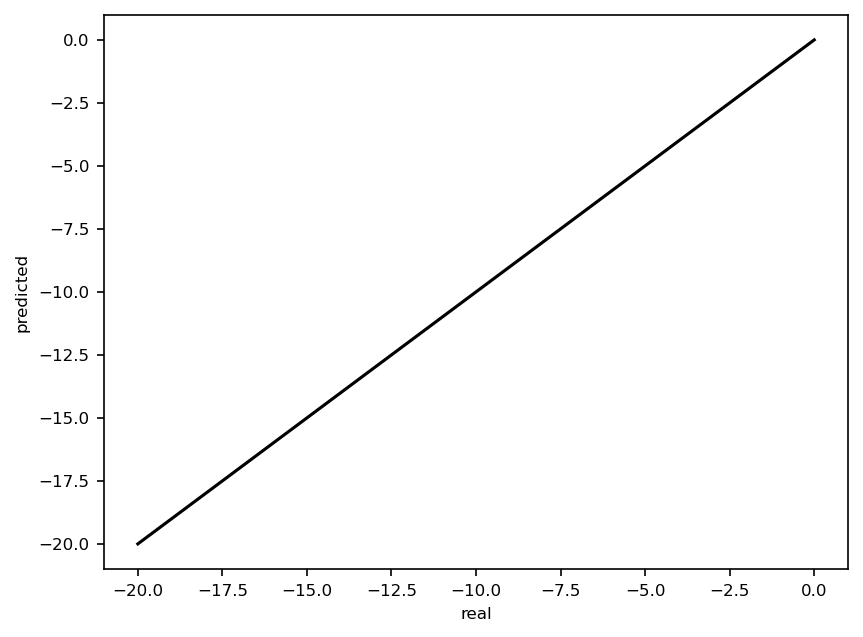

In [11]:
i = 0
x = np.linspace(-20,0,100)
print(n_test_hat[0][i])
print(n_test[0][i])
plt.plot(n_test[0][i],n_test_hat[0][i], 'o')
plt.plot(x,x,c='k')

plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

In [12]:
A = torch.rand(2,2).ravel()
B = torch.rand(2,2,2).ravel()
# print(A)

A = A.reshape(2,2)
B = B.reshape(2,2,2)

z = torch.rand(2)


torch.einsum("ij, j -> i", A, z) + torch.einsum("ijk, j, k -> i", B, z, z)

tensor([0.5726, 0.3669])